In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import style
plt.style.use('bmh')
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
import matplotlib.colors as colors
import control
from IPython import display
from collections import deque
import pickle
from Utilities.ParticleFilter import *
from Utilities.Dynamics_Constraints_Controller import *
from Utilities.cida import CIDA
import random
from scipy.linalg import sqrtm
import yaml

configuration = yaml.load(open('./configuration.yml', 'r'), Loader=yaml.Loader)

saveFigs = True
FigWidth = 2.5
FigHeight = 2.5
rx = configuration['rx']
T = configuration['T']
num_particles = configuration['num_particles']
Pred_Horizon_N = configuration['Pred_Horizon_N']
number_of_simulations = configuration['number_of_simulations']
LangrangeMultp = configuration['LangrangeMultp']
ru = configuration['ru']
ry = configuration['ry']
V = configuration['V']
tau = configuration['tau']

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=22,23 m=400 fp=0.042159 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [2]:
configuration['T']


100

In [3]:
theta = -np.pi+0.01
np.arctan2(np.sin(theta), np.cos(theta))

-3.1315926535897933

In [4]:
x0 = np.random.randn(rx,1)
x0[0] = 10
x0[2] = -np.pi/2
Cov0 = 0.2 * np.diag(np.ones(rx,))
num_particles = 1000
Pred_Horizon_N = 6
number_of_simulations = 100
LangrangeMultp = 1000
cida =  CIDA(x0, Cov0, num_particles, stateDynamics, measurementDynamics, Q, R,
                 Pred_Horizon_N, Controller, number_of_simulations, CostAndConstraints, LangrangeMultp)
cida.initialize(x0, Cov0)

RandomSearch method returns the desired control input, according to CIDA


In [5]:
cida.RandomSearch()

array([3.14159265])

sampleAverage is an inherited method that returns the state conditional mean of the particle filter

In [6]:
cida.sampleAverage()

array([[10.0097856 ],
       [-0.69350116],
       [-1.57981449]])

In [7]:
# A function to prepare the figure, its size, and plot the constraints set.

def Constraintsplot(ax):
    xc = np.linspace(-10,10,100)
    yc1 = np.sqrt(10**2-xc**2)
    yc2 = -np.sqrt(10**2-xc**2)
    ax.set_xlabel('$x\,\, (m)$', fontsize=9)
    ax.set_ylabel('$y\,\, (m)$', fontsize=9)
    ax.plot(xc,yc1,'r')
    ax.plot(xc,yc2,'r')
    ax.axis('equal')
    circle1 = plt.Circle((xs[0], ys[0]), rs[0], facecolor = 'blue')
    circle2 = plt.Circle((xs[1], ys[1]), rs[1], color='blue')
    circle3 = plt.Circle((xs[2], ys[2]), rs[2], color='blue')
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    ax.add_patch(circle3)
    pass

/var/folders/54/w5632h_d2qdffk_vmkbgn34m0000gn/T/ipykernel_85209/3188135494.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[0.693 0.84 1.0 0.505 1.0 0.999 0.0 0.16 0.002 0.856 1.0 0.962 0.0 0.583
 0.999 0.541 1.0 0.763 0.0 0.0 0.982 0.933 0.915 1.0 1.0 0.078 0.039 0.0
 1.0 0.14 0.955 0.126 0.969 0.973 0.0 0.698 0.319 0.871 0.0 0.828 0.991
 0.0 0.047 0.995 0.997 0.006 0.183 0.0 0.974 1.0]


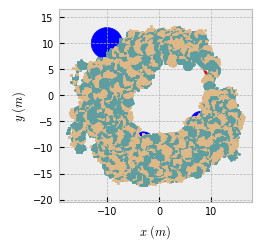

In [13]:
fig, ax= plt.subplots(figsize=(FigWidth,FigHeight))
Constraintsplot(ax)
Trials = 50
Rec_violation_CE = np.full((Trials,), np.zeros)
for j in range(Trials):
    T = configuration['T']
    cida.initialize(x0, Cov0)
    x_true = cida.particles[:,random.sample(range(0, cida.num_particles), 1)]
    AlphaAchieved_CE = np.zeros((T+1,))
    #ax.set_xlim((-15,15))
    #ax.set_ylim((-15,15))
    for k in range(T):
        AlphaAchieved_CE[k] = cida.ViolationProb()
        uSharp = Controller(cida.sampleAverage())
        #print(uSharp, controller(cida.sampleAverage()))
        ax.plot(cida.particles[0,:],cida.particles[1,:],'o', markersize=1.1,color=list(colors.cnames)[k%2+12], zorder=2)
        y = measurementDynamics(x_true, uSharp) + sqrtm(R).real @ np.random.randn(ry, 1)
        cida.Apply_PF(uSharp, y)
        x_true = stateDynamics(x_true, uSharp, sqrtm(Q).real @ np.random.randn(rx,))

    fig.savefig('Figures/CBF_and_CE.png',dpi=400, bbox_inches ="tight")

    AlphaAchieved_CE[T]=cida.ViolationProb()  
    Rec_violation_CE[j] = AlphaAchieved_CE.max()
fig.show()
print(Rec_violation_CE)




TypeError: 'collections.deque' object is not callable

0
1
2
3
4
5
6
7
8
9
10
11
12
13


TypeError: 'NoneType' object is not subscriptable

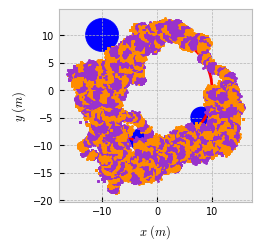

In [22]:
fig, ax= plt.subplots(figsize=(FigWidth,FigHeight))
Constraintsplot(ax)
Rec_violation_CIDA = np.full((Trials,), np.zeros)
for j in range(Trials-13):
    cida.initialize(x0, Cov0)
    x_true = cida.particles[:,random.sample(range(0, cida.num_particles), 1)]
    AlphaAchieved_cida = np.zeros((T+1,))
    print(j)
    j=j+13
    for k in range(T):
        AlphaAchieved_cida[k] = cida.ViolationProb()
        uSharp = cida.RandomSearch()
        ax.plot(cida.particles[0,:],cida.particles[1,:],'o', markersize=1.1,color=list(colors.cnames)[k%2 +30], zorder=2)
        y = measurementDynamics(x_true, uSharp) + sqrtm(R).real @ np.random.randn(ry, 1)
        cida.Apply_PF(uSharp, y)
        x_true = stateDynamics(x_true, uSharp, sqrtm(Q).real @ np.random.randn(rx,))


    AlphaAchieved_cida[T]=cida.ViolationProb()   
    Rec_violation_CIDA[j] = AlphaAchieved_cida.max()
print(Rec_violation_CIDA)




In [20]:
Rec_violation_CIDA

array([1.0, 0.0, <built-in function zeros>, <built-in function zeros>,
       <built-in function zeros>, <built-in function zeros>,
       <built-in function zeros>, <built-in function zeros>,
       <built-in function zeros>, <built-in function zeros>,
       <built-in function zeros>, <built-in function zeros>,
       <built-in function zeros>, <built-in function zeros>,
       <built-in function zeros>, <built-in function zeros>,
       <built-in function zeros>, <built-in function zeros>,
       <built-in function zeros>, <built-in function zeros>,
       <built-in function zeros>, <built-in function zeros>,
       <built-in function zeros>, <built-in function zeros>,
       <built-in function zeros>, <built-in function zeros>,
       <built-in function zeros>, <built-in function zeros>,
       <built-in function zeros>, <built-in function zeros>,
       <built-in function zeros>, <built-in function zeros>,
       <built-in function zeros>, <built-in function zeros>,
       <built-

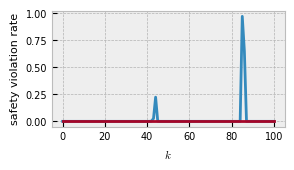

In [13]:
# Generating the violation rates figure
plt.style.use('bmh')
plt.figure(figsize=(3.0,1.5))
plt.plot(AlphaAchieved_CE)
plt.plot(AlphaAchieved_cida)
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels

plt.xlabel('$k$', fontsize=8)  
plt.ylabel('safety violation rate', fontsize=8) 
plt.savefig('Figures/violationRates.png', dpi=400, bbox_inches ="tight")

plt.show()